# Text classification

It's common task for machine learning and in this notebook is showen how it can be solved with deep learning, in particular pytorch.

In [1]:
import numpy as np
import pandas as pd

import re
import string
from collections import Counter

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import (
    DataLoader, random_split, Dataset
)
from torch.nn.utils.rnn import pad_sequence

import gensim.downloader as api

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
fasttext = api.load('glove-twitter-25')
fasttext.most_similar(positive=['man'])
fasttext.most_similar(positive=['king', 'woman'], negative=['man'])

[('meets', 0.8841924071311951),
 ('prince', 0.832163393497467),
 ('queen', 0.8257461190223694),
 ('’s', 0.8174097537994385),
 ('crow', 0.813499391078949),
 ('hunter', 0.8131037950515747),
 ('father', 0.8115834593772888),
 ('soldier', 0.81113600730896),
 ('mercy', 0.8082392811775208),
 ('hero', 0.8082264065742493)]

In [12]:
class Vocabulary:
    def __init__(self, texts: list[str], min_freq: int = 10):
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>')
        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    def word2idx(self, word: str):
        word = word.lower()
        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]
    
    def encode(self, text):
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    def build_vectors(self, fasttext):
        vectors = []
        
        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)

In [13]:
class IMDB(Dataset):
    def __init__(self, texts, labels, vocab):
        
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        text = torch.LongTensor(self.vocab.encode(text))
        label = torch.FloatTensor([label])

        return text, label

    def __len__(self):
        return len(self.texts)

In [14]:
data = pd.read_csv("texts_classification_files/IMDB Dataset.csv")
data["sentiment"] = data["sentiment"].replace({"positive" : 1, "negative" : 0})
vocab = Vocabulary(data["review"].values)

In [15]:
train_dataset, test_dataset = np.split(data, [45000], axis = 0)

In [16]:
train_dataset = IMDB(
    train_dataset["review"].values, 
    train_dataset["sentiment"].values, 
    vocab
)
test_dataset = IMDB(
    test_dataset["review"].values, 
    test_dataset["sentiment"].values, 
    vocab
)

In [17]:
pad_idx = len(vocab.vocabulary)

def collate_fn(batch):
    texts = pad_sequence(
        [b[0] for b in batch], 
        padding_value=pad_idx, 
        batch_first=True
    )
    labels = torch.stack([b[1] for b in batch])
    
    return texts, labels

In [18]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    collate_fn=collate_fn, 
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    collate_fn=collate_fn, 
    pin_memory=True
)

In [20]:
import torch.nn.functional as F


class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels = 1, 
                    out_channels = 16, 
                    kernel_size = (fs, embedding_dim)) 
                for fs in [2, 3, 4, 5]
            ]
        )

        self.fc = nn.Linear(4 * 16, 1)

        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]

        x = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in x]

        x = self.dropout(torch.cat(x, dim = 1))

        return self.fc(x)

In [21]:
model = TextCNN(vocab_size=len(vocab.vocabulary) + 1, embedding_dim=25, pad_idx=pad_idx)

In [22]:
vectors = vocab.build_vectors(fasttext)

In [23]:
model.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)

In [24]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc.item()


def train(model) -> tuple[float, float]:
    model.train()

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += binary_accuracy(output, y)

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    return train_loss, train_accuracy

In [25]:
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y)

    total_loss /= len(loader)
    total_accuracy /= len(loader)

    return total_loss, total_accuracy

In [26]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
#print(torch.cuda.get_device_name())

loss_fn = nn.BCEWithLogitsLoss()

cpu


In [28]:
model = model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

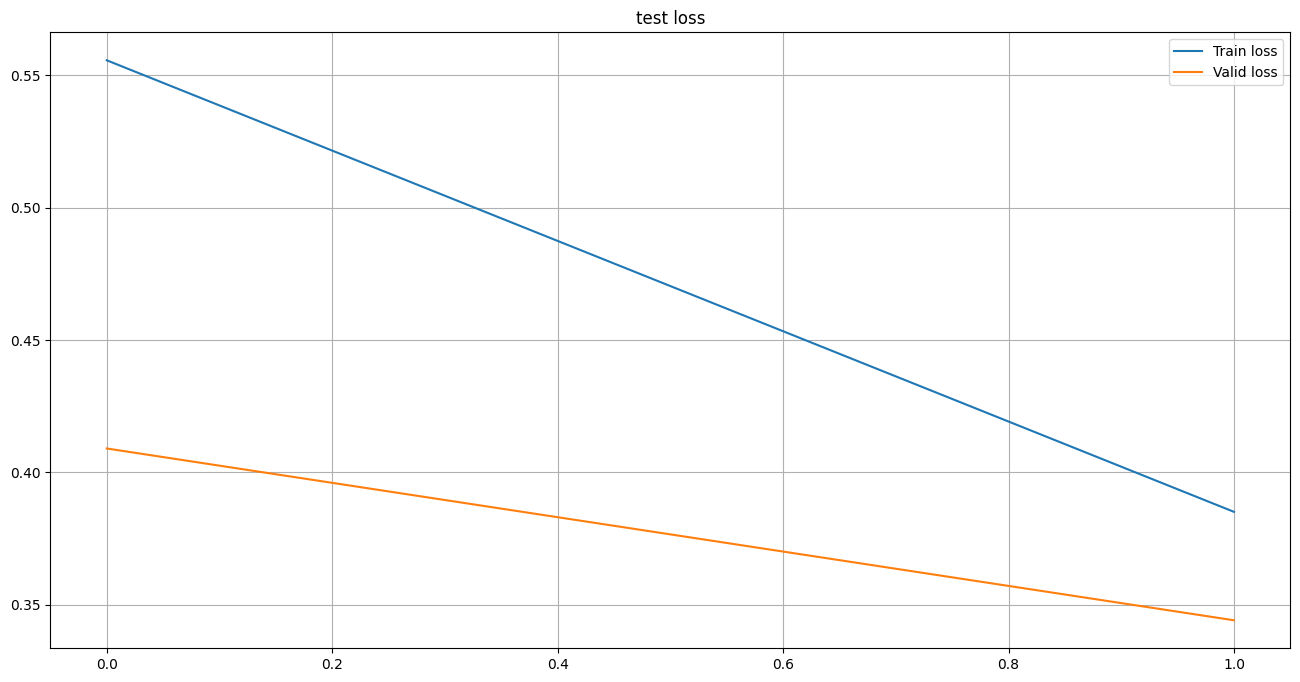

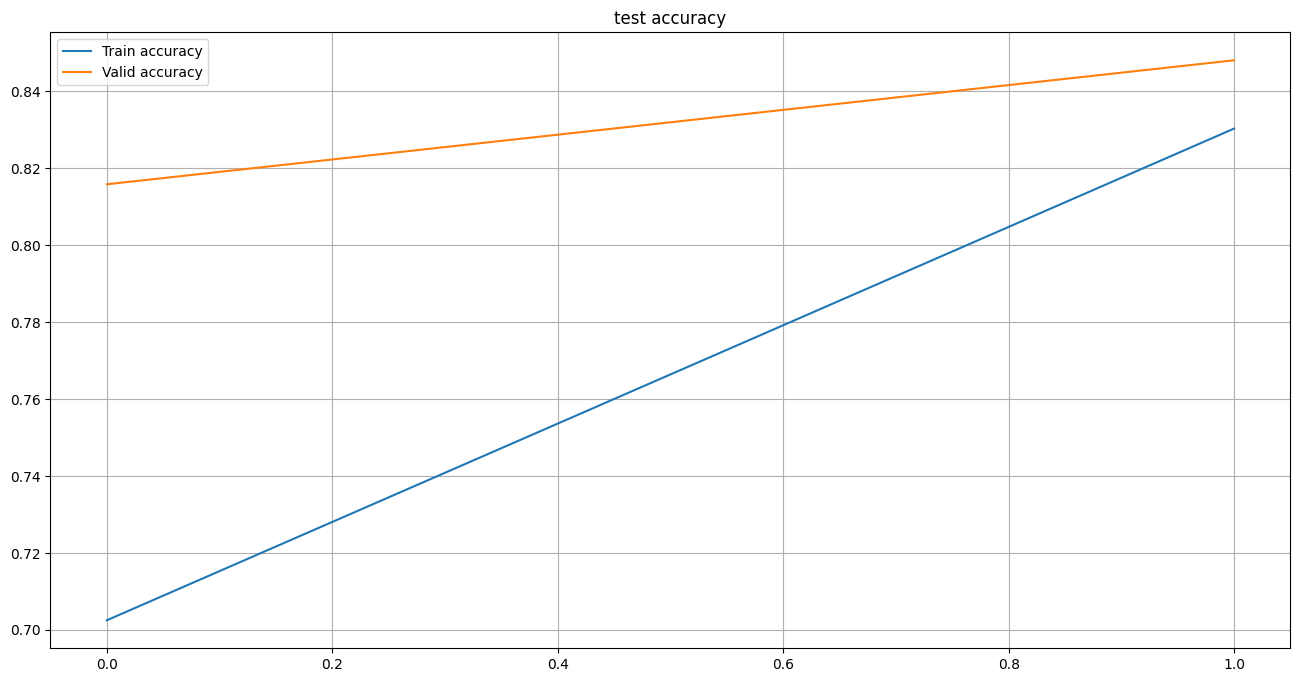

Train:  41%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 288/704 [00:31<00:45,  9.05it/s]


KeyboardInterrupt: 

In [29]:
train_loss_history, valid_loss_history = [], []
train_accuracy_history, valid_accuracy_history = [], []

for epoch in range(10):
    train_loss, train_accuracy = train(model)
    valid_loss, valid_accuracy = evaluate(model, test_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)

    train_accuracy_history.append(train_accuracy)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(
        train_loss_history, valid_loss_history,
        train_accuracy_history, valid_accuracy_history,
        "test"
    )